In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [244]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [245]:
zip_codes = crop_sim.load_zip("78704")
print(zip_codes)

     ZIP  latitude  longitude
0  78704   30.2428   -97.7658


In [246]:
# crop_sim.generate_near()

In [247]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [248]:
ecocrop_df = crop_sim.load_ecocrop()

In [249]:


# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 10

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)


In [250]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [251]:
print(zip_codes['loca_index'].values)

[(19, 19)]


In [252]:
lat, lon = zip_codes['loca_index'].values[0]

In [253]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [254]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, frost_tolerance)

In [255]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [256]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


In [257]:
view_window = 105
print(optimal_planting_ranges)

{85: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-12-25 12:00:00')]], 95: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-12-15 12:00:00')]], 105: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-12-05 12:00:00')]], 115: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-11-25 12:00:00')]], 125: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-11-15 12:00:00')]], 135: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-11-05 12:00:00')]], 145: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-10-26 12:00:00')]], 155: [[Timestamp('2022-10-07 12:00:00'), Timestamp('2022-10-16 12:00:00')]], 165: [], 175: []}


In [258]:
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[view_window]))

[(10, 7, 12, 5)]


In [259]:
%matplotlib widget

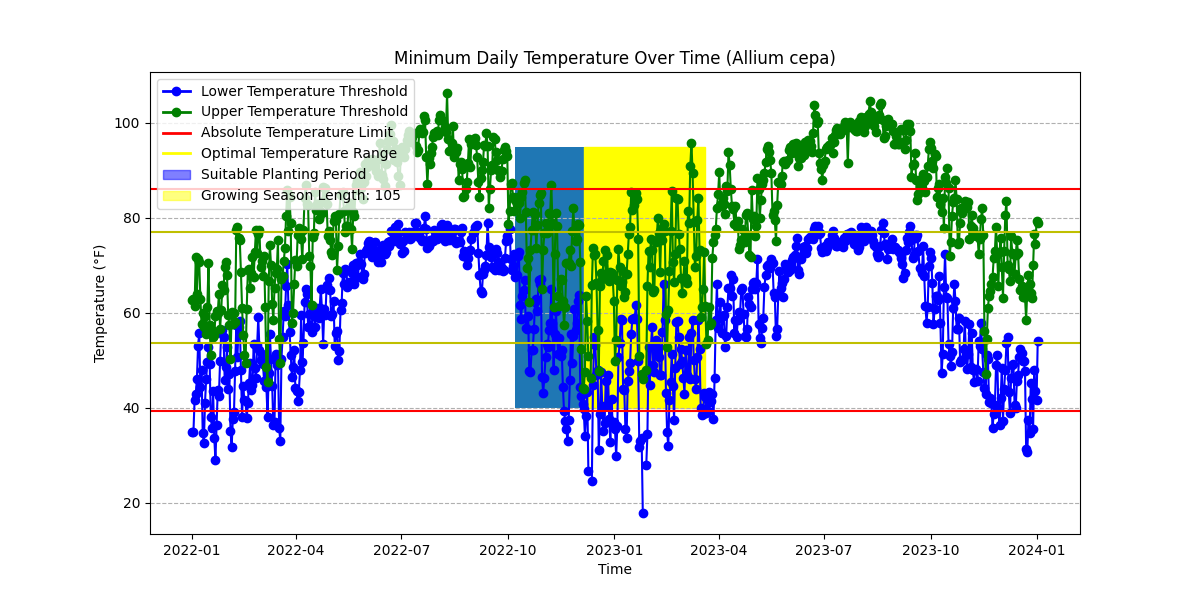

In [260]:

crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name)


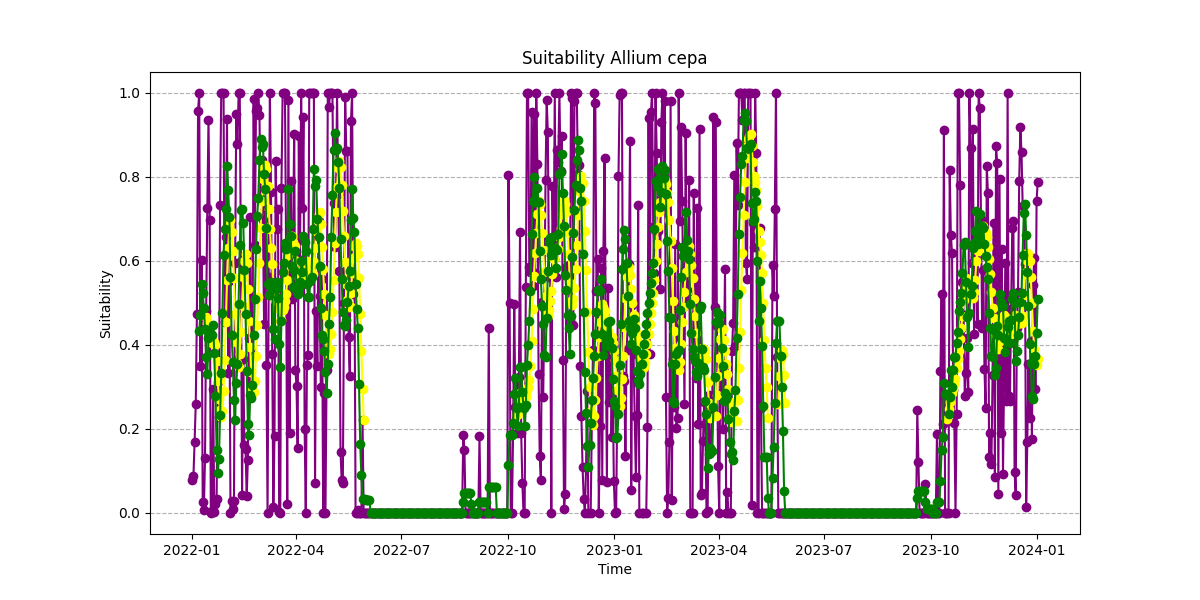

In [243]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)